In [2]:
"""

Extended Kalman Filter SLAM example

"""

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

From [Probabilistic Robotics](http://www.probabilistic-robotics.org/) book chapter 10.2 **SLAM with Extended Kalman Filters**.

---
We will use $g(u_t, x_{t-1})$ to represent the general form of the nonlinear motion functions.
$$
x_t = g(u_t, x_{t-1}) + \epsilon_t
= A_t x_{t-1} + B_t u_t + \epsilon_t
$$
In state-space representation, we can have the following form:
$$
g(u_t, x_{t-1}) = A_t x_{t-1} + B_t u_t
$$

Our measurement function takes the form of:
$$
z_t = h(x_t) + \delta_t
$$
where the nonlinear measurement function $h(x_t)$ can also be represented in state-space as:
$$
h(x_t) = C_t x_t
$$
where $C_t$ is the measurement matrix that defines the model of measurement (which maps state $x_t$ to measurement $z_t$).

---
We define actual agent's state as $x$, and use $y$ to denote the combined feature:
$$
\begin{split}
y_t 
&= 
\begin{pmatrix}
    x_t\\
    m
\end{pmatrix} \\
&=
\begin{pmatrix}
    x_t & y_t & \theta_t \\
    m_{1,x} & m_{1,y} & 0\\
    m_{2,x} & m_{2,y} & 0\\
    \cdots & \cdots & \cdots \\
    m_{N,x} & m_{N,y} & 0\\
\end{pmatrix} \\
\end{split}
$$
where $m$ denotes the landmarks observed so far and $N$ is the total number of landmarks.

---
In EKF, the two nonlinear functions $g(u_t, x_{t-1})$ and $h(x_t)$ are locally linearized through first-order Taylor expansion:
$$
g(u_t, y_{t-1}) \approx g(u_t, \mu_{t-1}) + G_t(y_{t-1} - \mu_{t-1})
$$
where 
$$
\begin{split}
G_t &= \frac{\partial}{\partial x} g(u_t, x_t) \\
&= \frac{\partial}{\partial x} \left( A_t x_{t-1} + B_t u_t \right) \\
&= A_t + \frac{\partial}{\partial x} \left( B_t u_t \right) \\
&= I + F_x^T g_t F_x
\end{split}
$$
is the Jacobian of the (non-linear) motion function, and
$$
g_t = \frac{\partial}{\partial x} \left( B_t u_t \right)
$$

---
$$
F_{x,k} = 
 \begin{pmatrix}
  1&0&0 & & 0\cdots0 & & 0&0&0 & & 0\cdots0 \\
  0&1&0 & & 0\cdots0 & & 0&0&0 & & 0\cdots0 \\
  0&0&1 & & 0\cdots0 & & 0&0&0 & & 0\cdots0 \\
  \\
  0&0&0 & & 0\cdots0 & & 1&0&0 & & 0\cdots0 \\
  0&0&0 & & 0\cdots0 & & 0&1&0 & & 0\cdots0 \\
  0&0&0 & & 0\cdots0 & & 0&0&1 & & 0\cdots0 \\
 \end{pmatrix}
$$

$$
H_t^k = \frac{1}{q_k} 
\begin{pmatrix}
   \sqrt{q_k}\delta_{k,x} & -\sqrt{q_k}\delta_{k,y} & 0 & -\sqrt{q_k}\delta_{k,x} & \sqrt{q_k}\delta_{k,y} \\
   \delta_{k,y} & \delta_{k,x} & -1 & -\delta_{k,y} & -\delta_{k,x}
\end{pmatrix}
F_{x,k}
$$

---
Compute Kalman gain $K_t^i$:
$$
K_t^i = \bar{\Sigma}_t {H_t^i}^T \left( H_t^i \bar{\Sigma}_t {H_t^i}^T + Q_t\right)^{-1}
$$

In [ ]:
class EKF_SLAM:
    show_animation = True
    
    # simulation parameters
    time_dt = 0.1    # time step [s]
    time_sim = 50.0  # total simulation time [s]
    ndim_state = 3    # state dimension [x, y, yaw]
    ndim_landmark = 2 # Landmark state dimension [x, y]
    sensor_max_range = 20.0 # maximum observation range of the simulated sensor
    M_DIST_TH = 2.0  # Threshold of Mahalanobis distance for data association.

    # EKF state covariance
    Q_t = np.diag([0.5, 0.5, np.deg2rad(30.0)])**2

    #  Simulation parameter
    Qsim = np.diag([0.2, np.deg2rad(1.0)])**2   # Covariance of process noise
    Rsim = np.diag([1.0, np.deg2rad(10.0)])**2  # Covariance of measurement noise

    # Initialize a bunch of intermediate matrices
    def __init__():
        
    def get_u(self):
        v = 1.0        # [m/s]
        yawrate = 0.1  # [rad/s]
        u = np.matrix([v, yawrate]).T
        return u

    def motion_model(self, x, u):
        # https://en.wikipedia.org/wiki/State-space_representation
        # state matrix 3x3
        A = np.matrix([[1.0, 0, 0],
                       [0, 1.0, 0],
                       [0, 0, 1.0]])
        # input matrix 3x2
        B = np.matrix([[time_dt * np.cos(x[2, 0]), 0],
                       [time_dt * np.sin(x[2, 0]), 0],
                       [0.0, DT]])
        # update state vector
        x = A * x + B * u
        return x
    
    def count_landmarks(x):
        # count number of landmarks in x
        n = (len(x) - ndim_state) // ndim_landmark
        return n

    def jacobian_motion(x, u):
        '''
        Jacobian of motion function g
        '''
        # mapping matrix Fx helps map actual state vector (dim_state)
        # into combined state vector (dim_state + dim_landmark*cnt_landmark)
        Fx = np.hstack(
            (
                np.eye(ndim_state),
                np.zeros((ndim_state, ndim_landmark * count_landmarks(x)))
            )
        )
        jBu = np.matrix([[0.0, 0.0, -time_dt * u[0] * np.sin(x[2, 0])],
                        [0.0, 0.0,   time_dt * u[0] * np.cos(x[2, 0])],
                        [0.0, 0.0, 0.0]])

        G = np.eye(ndim_state) + Fx.T * jBu * Fx

        return G, jBu
    
    def jacobian_H(q, sq, delta, x, i):
        '''
        Jacobian of measurement function h
        
        INPUT:
            q : squared delta_k
            sq: square root of q
            delta: location error between landmark i and agent
            x: current state
            i: index of current landmark
            
        OUTPUT:
            H: Jacobian of measurement function h
        '''
        G = np.matrix(
            [
                [-sq * delta[0, 0], - sq * delta[1, 0], 0, sq * delta[0, 0], sq * delta[1, 0]],
                [delta[1, 0], - delta[0, 0], - 1.0, - delta[1, 0], delta[0, 0]]
            ]
        )
        G = G / q
        # mapping matrix Fx helps map actual state vector (dim_state)
        # into combined state vector (dim_state + dim_landmark*cnt_landmark)
        num_landmarks = count_landmarks(x)
        Fx = np.hstack(
            (
                np.eye(ndim_state),
                np.zeros((ndim_state, ndim_landmark * num_landmarks))
            )
        ) # upper half of F_xk
        Fk = np.hstack(
            (
                np.zeros((ndim_landmark, ndim_state)), 
                np.zeros((ndim_landmark, ndim_landmark * (i - 1))),
                np.eye(ndim_landmark), 
                np.zeros((ndim_landmark, ndim_landmark * num_landmarks - ndim_landmark * i))
            )
        ) # lower half of F_xk
        F_xk = np.vstack((Fx, Fk))
        H = G * F_xk
        return H

    def get_landmark_pos(x, z):
        zp = np.zeros((2, 1))

        zp[0, 0] = x[0, 0] + z[0, 0] * math.cos(x[2, 0] + z[0, 1])
        zp[1, 0] = x[1, 0] + z[0, 0] * math.sin(x[2, 0] + z[0, 1])

        return zp

    def get_landmark_pos_from_state(x, idx):
        # get the idx-th landmark position from state matrix
        lm = x[(ndim_state + ndim_landmark * idx) : (ndim_state + ndim_landmark * (idx + 1)), :]
        return lm

    def offset_angle(angle):
        # make sure angle is from 0 to 2*pi
        return (angle + math.pi) % (2 * math.pi) - math.pi
   
    def observation(x, x_hat, u, landmarks):
        # update new state
        x = motion_model(x, u)

        # measurement noise
        z = np.matrix(np.zeros((0, 3)))
        # loop through all landmarks and append to measurement matrix if valid
        num_landmarks = len(landmarks[:, 0])
        for i in range(num_landmarks):
            dx = landmarks[i, 0] - x[0, 0]  # x distance from i-th landmark to the position
            dy = landmarks[i, 1] - x[1, 0]  # y distance from i-th landmark to the position
            d = math.sqrt(dx**2 + dy**2)             # true l-2 distance between landmark and current true position
            angle = offset_angle(math.atan2(dy, dx)) # true angle measurement
            if d <= sensor_max_range:
                # if the landmark is in the detactable range of the sensor
                d_hat = d + np.random.randn() * Qsim[0, 0]          # measured distance plus process noise
                angle_hat = angle + np.random.randn() * Qsim[1, 1]  # measured angle plus process noise
                # put together the measurement matrix for the i-th landmark
                zi = np.matrix([d_hat, angle_hat, i]) # measurement of i-th landmark
                z = np.vstack((z, zi))                # all measurements

        # add control noise to all input u dimensions
        ndim_u = len(u[:, 0])
        u_dims = []
        for i in range(ndim_u):
            u_dim.append(u[i, 0] + np.random.randn() * Rsim[i, i])    
        u_hat = np.matrix(u_dims).T
        # predict new state predicted x and u
        x_hat = motion_model(x_hat, u_hat)
        return x, z, x_hat, u_hat
    
    def calc_innovation(landmark_idx, landmark, x_hat, P_hat, z):
        # location delta
        delta = landmark - x_hat[0:2] 
        # predicted distance measurement
        q = (delta.T * delta)[0, 0]   
        sq = np.sqrt(q)
        # predicted angle measurement
        z_angle = math.atan2(delta[1], delta[0]) - xEst[2] 
        # put together, z_hat = predicted measurement vector
        z_hat = [sq, offset_angle(z_angle)]
        # innovation
        y = (z - z_hat).T
        y[1] = offset_angle(y[1])
        # Jacobian of measurement function
        H = jacobH(q, sq, delta, x_hat, landmark_idx + 1)
        # compute S, P_hat is the estimated covariance of measurement
        # and Q_t is the pre-defined covariance of state 
        # (we are only using) the upper-left 2-by-2 
        S = H * P_hat * H.T + Q_t[0:2, 0:2]
        
        return y, S, H
    
    def ekf_slam(x_hat, P_hat, u, z):
        # Prediction phase
        nS = ndim_state
        x_hat[0:ns] = motion_model(xEst[0:ns], u)
        G, Fx = jacob_motion(xEst[0:S], u)
        PEst[0:ns, 0:ns] = G.T * PEst[0:S, 0:S] * G + Fx.T * Cx * Fx
        initP = np.eye(2)

        # Update phase
        ndim_z = len(z[:, 0])
        for iz in range(ndim_z):  # for each observation
            minid = search_correspond_LM_ID(xEst, PEst, z[iz, 0:2])

            nLM = calc_n_LM(xEst)
            if minid == nLM:
                print("New LM")
                # Extend state and covariance matrix
                xAug = np.vstack((xEst, calc_LM_Pos(xEst, z[iz, :])))
                PAug = np.vstack((np.hstack((PEst, np.zeros((len(xEst), LM_SIZE)))),
                                  np.hstack((np.zeros((LM_SIZE, len(xEst))), initP))))
                xEst = xAug
                PEst = PAug

            lm = get_LM_Pos_from_state(xEst, minid)
            y, S, H = calc_innovation(lm, xEst, PEst, z[iz, 0:2], minid)

            K = PEst * H.T * np.linalg.inv(S)
            xEst = xEst + K * y
            PEst = (np.eye(len(xEst)) - K * H) * PEst

        xEst[2] = pi_2_pi(xEst[2])

        return xEst, PEst


In [9]:
Q_t = np.diag([0.5, 0.5, np.deg2rad(30.0)])**2

array([[0.25      , 0.        , 0.        ],
       [0.        , 0.25      , 0.        ],
       [0.        , 0.        , 0.27415568]])

In [3]:
np.hstack(
            (
                np.eye(3), 
                np.zeros((3, 2 * 5))
            )
        )

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
# EKF state covariance
Cx = np.diag([0.5, 0.5, np.deg2rad(30.0)])**2

#  Simulation parameter
Qsim = np.diag([0.2, np.deg2rad(1.0)])**2
Rsim = np.diag([1.0, np.deg2rad(10.0)])**2

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range
M_DIST_TH = 2.0  # Threshold of Mahalanobis distance for data association.
STATE_SIZE = 3  # State size [x,y,yaw]
LM_SIZE = 2  # LM srate size [x,y]

show_animation = True


def ekf_slam(xEst, PEst, u, z):

    # Predict
    S = STATE_SIZE
    xEst[0:S] = motion_model(xEst[0:S], u)
    G, Fx = jacob_motion(xEst[0:S], u)
    PEst[0:S, 0:S] = G.T * PEst[0:S, 0:S] * G + Fx.T * Cx * Fx
    initP = np.eye(2)

    # Update
    for iz in range(len(z[:, 0])):  # for each observation
        minid = search_correspond_LM_ID(xEst, PEst, z[iz, 0:2])

        nLM = calc_n_LM(xEst)
        if minid == nLM:
            print("New LM")
            # Extend state and covariance matrix
            xAug = np.vstack((xEst, calc_LM_Pos(xEst, z[iz, :])))
            PAug = np.vstack((np.hstack((PEst, np.zeros((len(xEst), LM_SIZE)))),
                              np.hstack((np.zeros((LM_SIZE, len(xEst))), initP))))
            xEst = xAug
            PEst = PAug

        lm = get_LM_Pos_from_state(xEst, minid)
        y, S, H = calc_innovation(lm, xEst, PEst, z[iz, 0:2], minid)

        K = PEst * H.T * np.linalg.inv(S)
        xEst = xEst + K * y
        PEst = (np.eye(len(xEst)) - K * H) * PEst

    xEst[2] = pi_2_pi(xEst[2])

    return xEst, PEst


def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.matrix([v, yawrate]).T
    return u


def observation(xTrue, xd, u, landmarks):

    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = np.matrix(np.zeros((0, 3)))
    
    num_landmarks = len(landmarks[:, 0])
    for i in range(num_landmarks):

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.sqrt(dx**2 + dy**2)
        angle = pi_2_pi(math.atan2(dy, dx))
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            anglen = angle + np.random.randn() * Qsim[1, 1]  # add noise
            zi = np.matrix([dn, anglen, i])
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1]
    ud = np.matrix([ud1, ud2]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud


def motion_model(x, u):
    # https://en.wikipedia.org/wiki/State-space_representation
    # state matrix 3x3
    A = np.matrix([[1.0, 0, 0],
                   [0, 1.0, 0],
                   [0, 0, 1.0]])
    # input matrix 3x2
    B = np.matrix([[DT * math.cos(x[2, 0]), 0],
                   [DT * math.sin(x[2, 0]), 0],
                   [0.0, DT]])
    # update state vector
    x = A * x + B * u
    return x


def calc_n_LM(x):
    n = int((len(x) - STATE_SIZE) / LM_SIZE)
    return n


def jacob_motion(x, u):

    Fx = np.hstack((np.eye(STATE_SIZE), np.zeros(
        (STATE_SIZE, LM_SIZE * calc_n_LM(x)))))

    jF = np.matrix([[0.0, 0.0, -DT * u[0] * math.sin(x[2, 0])],
                    [0.0, 0.0, DT * u[0] * math.cos(x[2, 0])],
                    [0.0, 0.0, 0.0]])

    G = np.eye(STATE_SIZE) + Fx.T * jF * Fx

    return G, Fx,


def calc_LM_Pos(x, z):

    zp = np.zeros((2, 1))

    zp[0, 0] = x[0, 0] + z[0, 0] * math.cos(x[2, 0] + z[0, 1])
    zp[1, 0] = x[1, 0] + z[0, 0] * math.sin(x[2, 0] + z[0, 1])

    return zp


def get_LM_Pos_from_state(x, ind):

    lm = x[STATE_SIZE + LM_SIZE * ind: STATE_SIZE + LM_SIZE * (ind + 1), :]

    return lm


def search_correspond_LM_ID(xAug, PAug, zi):
    """
    Landmark association with Mahalanobis distance
    """
    nLM = calc_n_LM(xAug)

    mdist = []

    for i in range(nLM):
        lm = get_LM_Pos_from_state(xAug, i)
        y, S, H = calc_innovation(lm, xAug, PAug, zi, i)
        mdist.append(y.T * np.linalg.inv(S) * y)

    mdist.append(M_DIST_TH)  # new landmark

    minid = mdist.index(min(mdist))

    return minid


def calc_innovation(lm, xEst, PEst, z, LMid):
    delta = lm - xEst[0:2]
    q = (delta.T * delta)[0, 0]
    zangle = math.atan2(delta[1], delta[0]) - xEst[2]
    zp = [math.sqrt(q), pi_2_pi(zangle)]
    y = (z - zp).T
    y[1] = pi_2_pi(y[1])
    H = jacobH(q, delta, xEst, LMid + 1)
    S = H * PEst * H.T + Cx[0:2, 0:2]

    return y, S, H


def jacobH(q, delta, x, i):
    sq = math.sqrt(q)
    G = np.matrix([[-sq * delta[0, 0], - sq * delta[1, 0], 0, sq * delta[0, 0], sq * delta[1, 0]],
                   [delta[1, 0], - delta[0, 0], - 1.0, - delta[1, 0], delta[0, 0]]])

    G = G / q
    nLM = calc_n_LM(x)
    F1 = np.hstack((np.eye(3), np.zeros((3, 2 * nLM))))
    F2 = np.hstack((np.zeros((2, 3)), np.zeros((2, 2 * (i - 1))),
                    np.eye(2), np.zeros((2, 2 * nLM - 2 * i))))

    F = np.vstack((F1, F2))

    H = G * F

    return H


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi


def main():
    #print(__file__ + " start!!")

    time = 0.0

    # RFID positions [x, y]
    RFID = np.array([[10.0, -2.0],
                     [15.0, 10.0],
                     [3.0, 15.0],
                     [-5.0, 20.0]])

    # State Vector [x y yaw v]'
    xEst = np.matrix(np.zeros((STATE_SIZE, 1)))
    xTrue = np.matrix(np.zeros((STATE_SIZE, 1)))
    PEst = np.eye(STATE_SIZE)

    xDR = np.matrix(np.zeros((STATE_SIZE, 1)))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

        xEst, PEst = ekf_slam(xEst, PEst, ud, z)

        x_state = xEst[0:STATE_SIZE]

        # store data history
        hxEst = np.hstack((hxEst, x_state))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))

        if show_animation:
            #plt.cla()

            plt.plot(RFID[:, 0], RFID[:, 1], "*k")
            plt.plot(xEst[0], xEst[1], ".r")

            # plot landmark
            for i in range(calc_n_LM(xEst)):
                plt.plot(xEst[STATE_SIZE + i * 2],
                         xEst[STATE_SIZE + i * 2 + 1], "xg")

            plt.plot(np.array(hxTrue[0, :]).flatten(),
                     np.array(hxTrue[1, :]).flatten(), "-b")
            plt.plot(np.array(hxDR[0, :]).flatten(),
                     np.array(hxDR[1, :]).flatten(), "-k")
            plt.plot(np.array(hxEst[0, :]).flatten(),
                     np.array(hxEst[1, :]).flatten(), "-r")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)

New LM
New LM
New LM


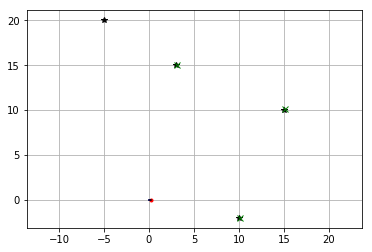

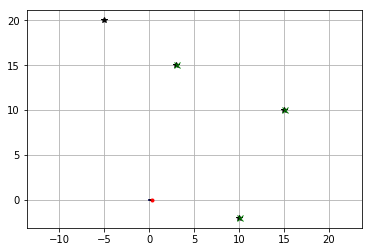

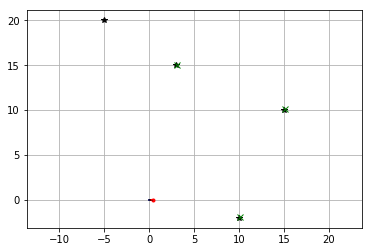

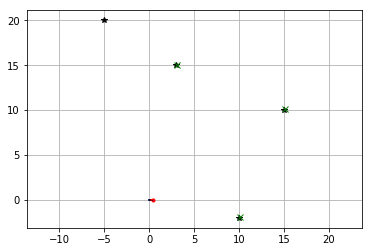

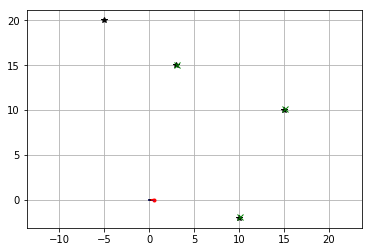

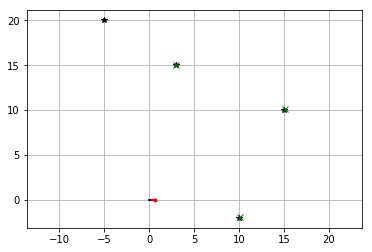

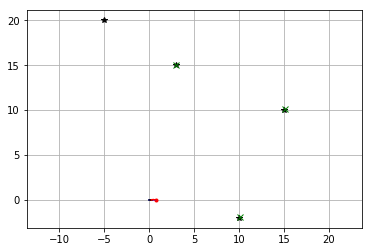

KeyboardInterrupt: 

In [10]:
main()